In [1]:
import librosa
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from PIL import Image
import io

2025-04-25 10:14:46.259977: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Experiment 1: Turning wavs to mfcc 
See how they compare to images from gabriel after removing white border

In [ ]:
#base path for each kind of data
train_dataset_path = '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_train'
eval_dataset_path = '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_eval'

dev_dataset_path = '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_dev'
print(train_dataset_path)

In [ ]:
#Store names of wav files in list (They're in order) 
train_audio_files = sorted([f for f in os.listdir(train_dataset_path) if os.path.isfile(os.path.join(train_dataset_path, f))])
eval_audio_files = sorted([f for f in os.listdir(eval_dataset_path) if os.path.isfile(os.path.join(eval_dataset_path, f))])
dev_audio_files = sorted([f for f in os.listdir(dev_dataset_path) if os.path.isfile(os.path.join(dev_dataset_path, f))])

print(train_audio_files[:5])
print(eval_audio_files[:5])
print(dev_audio_files[:5])


In [ ]:
#Function for normalizing each mfcc row.
#Used instead of scale() from gabriel's code because its faster and doesn't display error message
def safe_zscore(mfcc, eps=1e-6):
    mean = np.mean(mfcc, axis=1, keepdims=True)
    std = np.std(mfcc, axis=1, keepdims=True)
    return (mfcc - mean) / (std + eps)

In [ ]:
#Converts a wav file into a mfcc image
#Originally from gabriel's code
def wav_to_mfcc(file_path, sample_rate, n_fft, n_mfcc, hop_length):    
    y, sr = librosa.load(file_path, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=y, sr=sr,
                            n_fft=n_fft, n_mfcc=n_mfcc,
                            hop_length=hop_length)
    mfccs = safe_zscore(mfcc)

    librosa.display.specshow(mfccs, sr=sample_rate,
                                    n_fft=n_fft,
                                    hop_length=hop_length)
    
    # #fig2img
    buf = io.BytesIO()
    fig = plt.gcf()
    fig.savefig(buf, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")


    # # Resize to 200x200
    img_resized = img.resize((200, 200))

    # # Convert to float and normalize to [0, 1]
    img_array = np.array(img_resized).astype("float32") / 255.0
    return img_array
    
    # sample_rate = 16000
    # frame_len = 0.025 # 25ms
    # hop_len = 0.01 # 10ms
    # n_fft = int(sample_rate * frame_len)
    # hop_length = int(sample_rate * hop_len)
    # n_mfcc = 13

In [ ]:
#For testing wav_to_mfcc function and see how mfcc looks like
dummy_path = train_dataset_path + "/" + train_audio_files[3012]
dummy_mfcc = wav_to_mfcc(dummy_path, 16000, int(16000 * 0.025), 13, int(16000 * 0.01))

# dummy_mfcc.shape
# plt.imshow(dummy_mfcc)
# plt.title("MFCC")
# plt.axis("off")
# plt.show()

img = Image.fromarray((dummy_mfcc * 255).astype(np.uint8))
img.show()
dummy_mfcc.shape

In [ ]:
#Save all wav in folder into mfcc function
def allWavtoMFCC(files_array, dataset_path):
    mfcc_arr = []
    for file in files_array:
        file_path = os.path.join(dataset_path, file)
        mfcc = wav_to_mfcc(file_path, 16000, int(16000 * 0.025), 13, int(16000 * 0.01))
        mfcc_arr.append(mfcc)
    return np.array(mfcc_arr)
        
    

In [ ]:
X_train = allWavtoMFCC(train_audio_files, train_dataset_path)


In [ ]:
X_test = allWavtoMFCC(eval_audio_files, eval_dataset_path)
X_val = allWavtoMFCC(dev_audio_files, dev_dataset_path)

In [ ]:
#Function for getting x and y data for a specific kind of dataset
#For example, pass in addresses for training csv and mfcc images to get X_train and y_train
def load_labels_from_csv(csv_path):
    #Get values from csv
    df = pd.read_csv(csv_path)

    label_map = {'genuine': 0, 'spoof': 1}
    #Create arrays with the addresses and another one with the labels
    labels = df['Label'].map(label_map)
        
    return np.array(labels)     

In [ ]:
y_train = load_labels_from_csv(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_train.csv',

)

y_test = load_labels_from_csv(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_eval.csv'
)

y_val = load_labels_from_csv(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_dev.csv'
)

# Experiment 2: Load MFCC Data
From Gabriel's MFCC folder

In [2]:
#Function for getting x and y data for a specific kind of dataset
#For example, pass in addresses for training csv and mfcc images to get X_train and y_train
def load_images_from_csv(csv_path, image_dir):
    #Get values from csv
    df = pd.read_csv(csv_path)

    #For csv, create a new column that has the full path to images
    df['filepath'] = df['File'].apply(lambda fname: os.path.join(image_dir, fname.replace('.wav', '.png')))

    label_map = {'genuine': 0, 'spoof': 1}
    #Create arrays with the addresses and another one with the labels
    labels = df['Label'].map(label_map)
    images = []
    for path in df['filepath']:
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)  # or 1 for grayscale
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0.0, 1.0]
        images.append(img.numpy())
        
    return np.array(images), np.array(labels)     
   

In [3]:
X_train, y_train = load_images_from_csv(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_train.csv',
    '/home/enriq115/dev/research/cs478/FinalProject/Dataset/MFCC/ASVspoof2017_V2_train'
)

X_test, y_test = load_images_from_csv(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_eval.csv',
    '/home/enriq115/dev/research/cs478/FinalProject/Dataset/MFCC/ASVspoof2017_V2_eval'
)

X_val, y_val = load_images_from_csv(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_dev.csv',
    '/home/enriq115/dev/research/cs478/FinalProject/Dataset/MFCC/ASVspoof2017_V2_dev'
)

In [ ]:
X_val[1]
# # Show the first image in the array
plt.imshow(X_val[0])  # assumes pixel values are already in [0, 1] or [0, 255]
plt.title("First Image from X_train")
plt.axis('off')  # Hide axis ticks
plt.show()


In [4]:
from sklearn.utils import shuffle

#Shuffle data for train and val to avoid the model generalizing stuff
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

# CNN Model (as accurate as possible)

In [5]:
def create_model():
    tf.random.set_seed(42) 
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(200,200,3)))

    # First 2D Conv Layer and 2d Max Pooling
    model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    # Global Max Pooling
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.GlobalMaxPooling2D())  # This reduces spatial dimensions to 1D feature vector


    # Fully connected output
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    model.summary()
    return model


In [6]:

model = create_model()

early_stop = callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 6,
    restore_best_weights=True
)
model.fit(
    X_train, 
    y_train,    
    epochs=30,
    steps_per_epoch=8,
    validation_data = (X_val, y_val),
    callbacks=[early_stop]
)

/home/enriq115/miniconda3/envs/my_env/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,457 (29.13 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5252 - loss: 3.8105 - val_accuracy: 0.5556 - val_loss: 0.6879
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5083 - loss: 2.0748 - val_accuracy: 0.5556 - val_loss: 0.6872
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5365 - loss: 1.4313 - val_accuracy: 0.5556 - val_loss: 0.6865
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5458 - loss: 1.1148 - val_accuracy: 0.5556 - val_loss: 0.6866
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5706 - loss: 0.9105 - val_accuracy: 0.5556 - val_loss: 0.6865
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6236 - loss: 0.7247 - val_accuracy: 0.5556 - val_loss: 0.6861
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6762 - loss: 0.6074 - val_accuracy: 0.5556 - val_loss: 0.6856
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7106 - loss: 0.5674 - val_accuracy: 0.5556 - val_loss: 0.6849
Epoch 9/

# Predict on data

In [7]:
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred > 0.5).astype(int).flatten()

416/416 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score, accuracy_score


print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
f1 = f1_score(y_test, y_pred)
print(f"F1 Score (Spoof as Positive): {f1:.4f}")

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score (Spoof as Positive): {acc:.4f}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score (Spoof as Positive): {recall:.4f}")

precision = precision_score(y_test, y_pred)
print(f"Precision Score (Spoof as Positive): {precision:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.65      0.26      1298
           1       0.94      0.64      0.76     12008

    accuracy                           0.64     13306
   macro avg       0.55      0.64      0.51     13306
weighted avg       0.87      0.64      0.71     13306

F1 Score (Spoof as Positive): 0.7595
Accuracy Score (Spoof as Positive): 0.6370
Recall Score (Spoof as Positive): 0.6352
Precision Score (Spoof as Positive): 0.9444


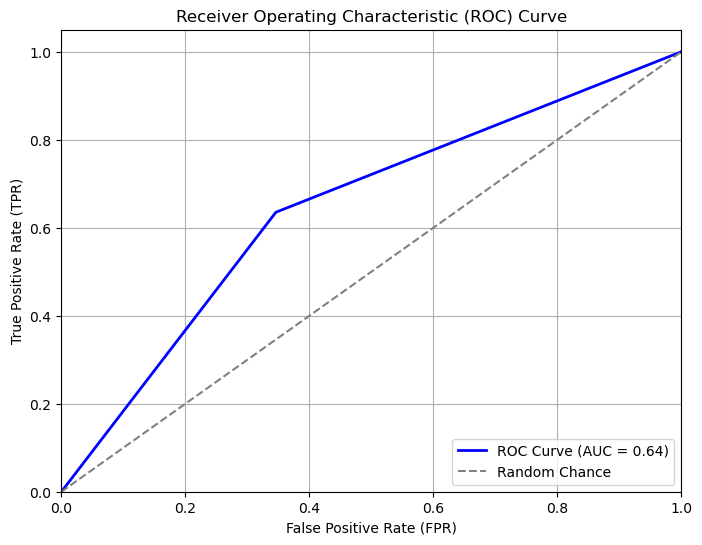

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Flatten if needed
y_test_flat = y_test.ravel()
y_pred_probs_flat = y_pred.ravel()

# Get FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_probs_flat)

# Area Under Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
